In [16]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression

#### Шаг 1: Очистка данных от выбросов и пропусков
Для этого будем проверять, есть ли в данных пропуски и использовать методы для выявления выбросов (например, метод межквартильного размаха).

In [17]:
# Загрузка данных
url = "https://github.com/YBI-Foundation/Dataset/raw/main/NSE%20Gold%20CPI%20.xlsx"
data = pd.read_excel(url, engine='openpyxl')

# Очистка данных от пропусков
data_cleaned = data.dropna()

# Очистка данных от выбросов методом межквартильного размаха (IQR)
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Применим очистку для всех количественных переменных
for col in ['NSE', 'Gold', 'CPI']:
    data_cleaned = remove_outliers(data_cleaned, col)

#### Шаг 2: Построение доверительных интервалов для двух переменных
Выберем две количественные переменные (например, NSE и Gold) и рассчитаем для них 95% доверительные интервалы.

In [18]:
# Шаг 2: Доверительные интервалы для NSE и Gold
def confidence_interval(data, column, confidence=0.95):
    mean = data[column].mean()
    sem = stats.sem(data[column])  # Стандартная ошибка среднего
    margin = sem * stats.t.ppf((1 + confidence) / 2, len(data[column]) - 1)
    return mean - margin, mean + margin

ci_nse = confidence_interval(data_cleaned, 'NSE')
ci_gold = confidence_interval(data_cleaned, 'Gold')

print(f"95% доверительный интервал для NSE: {ci_nse}")
print(f"95% доверительный интервал для Gold: {ci_gold}")

95% доверительный интервал для NSE: (np.float64(10707.4095551619), np.float64(11366.128530695245))
95% доверительный интервал для Gold: (np.float64(1329.339324615205), np.float64(1463.9225801467))


Для NSE: вероятностью 95% истинное среднее значение индекса NSE лежит в диапазоне (10707.41, 11366.13).

Для Gold: вероятностью 95% истинное среднее значение индекса NSE лежит в диапазоне  (1329.34, 1463.92).

#### Шаг 3: Проверка нормальности распределения
Для этого используем тест Шапиро-Уилка или тест Д’Агостино, а также визуальные методы, такие как гистограммы и Q-Q графики.

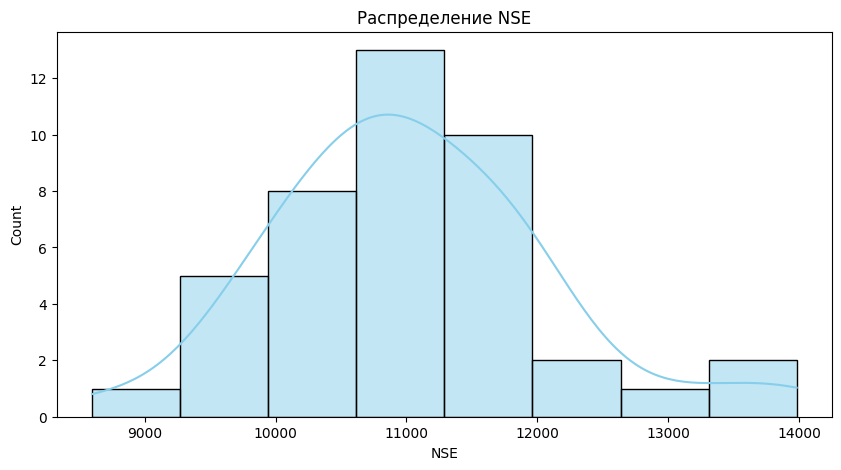

Тест Шапиро-Уилка для NSE: p-value = 0.2558


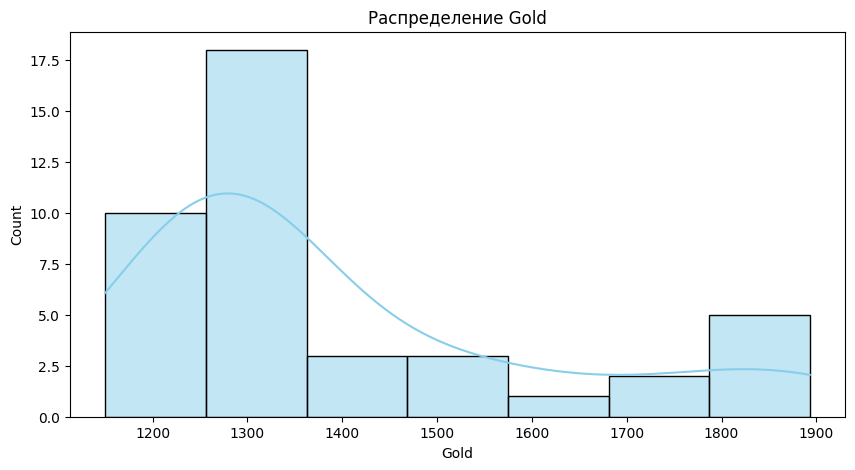

Тест Шапиро-Уилка для Gold: p-value = 0.0000


In [19]:
# Шаг 3: Проверка нормальности распределения
normality_tests = {}
for column in ['NSE', 'Gold']:
    normality_tests[column] = stats.shapiro(data_cleaned[column])

    # Визуализация распределения
    plt.figure(figsize=(10, 5))
    sns.histplot(data_cleaned[column], kde=True, color='skyblue')
    plt.title(f'Распределение {column}')
    plt.show()

    print(f"Тест Шапиро-Уилка для {column}: p-value = {normality_tests[column].pvalue:.4f}")

Для NSE: P-value = 0.2558 (> 0.05). Согласно тесту Шапиро-Уилка, распределение индекса NSE не отличается от нормального. Гипотеза о нормальности принимается.

Для Gold: P-value = 0.0000 (< 0.05). Для цены золота гипотеза о нормальности распределения отвергается. Распределение золота существенно отличается от нормального.

#### Шаг 4: Тестирование гипотезы о равенстве средних значений
Используем тесты (двухвыборочный t-тест или тест Манна-Уитни) для двух групп наблюдений, разделив данные по времени или уровню одной из переменных.

In [20]:
# Шаг 4: Двухвыборочный t-тест или тест Манна-Уитни
# Разделим данные на две группы (например, по медиане Gold)
median_gold = data_cleaned['Gold'].median()
group1 = data_cleaned[data_cleaned['Gold'] <= median_gold]['NSE']
group2 = data_cleaned[data_cleaned['Gold'] > median_gold]['NSE']

# Выбор теста
if all(test.pvalue > 0.05 for test in normality_tests.values()):  # Нормальное распределение
    ttest_result = stats.ttest_ind(group1, group2)
    test_type = "Двухвыборочный t-тест"
else:  # Ненормальное распределение
    ttest_result = stats.mannwhitneyu(group1, group2)
    test_type = "Тест Манна-Уитни"

print(f"{test_type}: p-value = {ttest_result.pvalue:.4f}")

Тест Манна-Уитни: p-value = 0.0147


P-value = 0.0147 (< 0.05).
Тест сравнивает распределения индекса NSE в двух группах (выделенных по медиане цены золота).

Низкое значение p-value указывает на статистически значимые различия между группами.

Распределение индекса NSE в этих группах различается, что говорит о возможной связи между NSE и уровнем цены золота.

#### Шаг 5: Корреляция и точечная диаграмма
Построим scatterplot и рассчитаем коэффициент корреляции между двумя переменными.

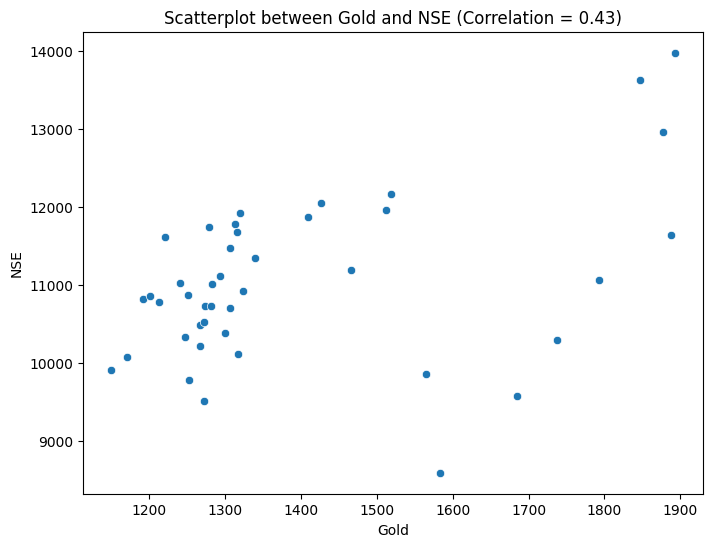

In [21]:
# Шаг 5: Корреляция и scatterplot
correlation = data_cleaned[['NSE', 'Gold']].corr().iloc[0, 1]

# Построение точечной диаграммы
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Gold', y='NSE', data=data_cleaned)
plt.title(f"Scatterplot between Gold and NSE (Correlation = {correlation:.2f})")
plt.show()

#### Шаг 6: Линейная регрессия и прогноз
Оценим линейную регрессионную модель и на ее основе построим прогноз.

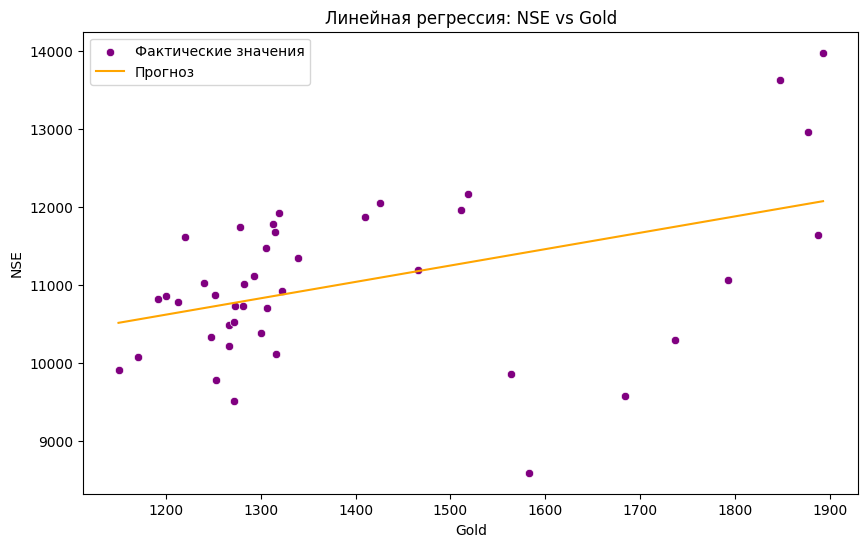

Коэффициент регрессии: 2.0986
Свободный член: 8105.7723


In [22]:
# Шаг 6: Линейная регрессия
X = data_cleaned[['Gold']]
y = data_cleaned['NSE']
reg_model = LinearRegression()
reg_model.fit(X, y)

# Построение прогноза
data_cleaned['Predicted_NSE'] = reg_model.predict(X)

# Визуализация регрессии
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Gold', y='NSE', data=data_cleaned, label='Фактические значения', color='purple')
sns.lineplot(x='Gold', y='Predicted_NSE', data=data_cleaned, label='Прогноз', color='orange')
plt.title("Линейная регрессия: NSE vs Gold")
plt.legend()
plt.show()

# Вывод результатов
print(f"Коэффициент регрессии: {reg_model.coef_[0]:.4f}")
print(f"Свободный член: {reg_model.intercept_:.4f}")

#### Коэффициент регрессии (2.0986):

Указывает, что при увеличении цены золота на 1 единицу, индекс NSE увеличивается в среднем на 2.10 единиц.

Сильная положительная связь между ценой золота и индексом NSE.

#### Свободный член (8105.7723):

Это прогнозируемое значение индекса NSE, если цена золота равна 0. Оно выступает как базовая линия.

##### Общие выводы

- Индекс NSE и цены золота имеют статистически значимую связь, подтвержденную как визуально (scatterplot), так и математически (линейная регрессия).

- Распределение индекса NSE ближе к нормальному, тогда как цены золота не нормальны.

- Различия в группах по медиане цены золота указывают на существование взаимосвязи между этими переменными.